预测对的结果数目为： 115
预测错的结果数目为： 55
验证集准确率 (Accuracy): 0.6765
验证集精确率 (Precision): 0.7028
验证集召回率 (Recall): 0.6765
验证集 F1 值: 0.6798
验证集 Cohen’s Kappa 系数: 0.5498

分类报告:
                  precision    recall  f1-score   support

            fir       0.61      0.68      0.64        53
           pine       1.00      0.60      0.75        30
         spruce       0.63      0.68      0.66        57
trembling aspen       0.71      0.73      0.72        30

       accuracy                           0.68       170
      macro avg       0.74      0.67      0.69       170
   weighted avg       0.70      0.68      0.68       170



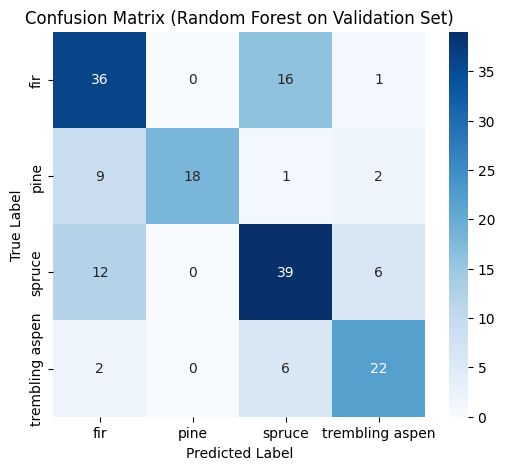


混淆矩阵：
                  fir  pine  spruce  trembling aspen
fir               36     0      16                1
pine               9    18       1                2
spruce            12     0      39                6
trembling aspen    2     0       6               22


In [10]:
import os
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report

# 标签映射
label_mapping = {
    0: 'fir',
    1: 'pine',
    2: 'spruce',
    3: 'trembling aspen'
}

def get_labels(label_dir, image_files):
    labels = []
    for image_file in image_files:
        label_file = os.path.join(label_dir, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))
        with open(label_file, 'r') as f:
            label_data = f.readlines()
            image_labels = []
            for line in label_data:
                class_id = int(line.split()[0])
                image_labels.append(class_id)
            labels.append(image_labels)
    return labels

def extract_lbp_and_glcm_features(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    radius = 1
    n_points = 8 * radius
    lbp_image = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_features = [contrast, homogeneity, energy, correlation]

    features = np.hstack([lbp_hist, glcm_features])
    return features

def load_dataset(image_folder, label_folder):
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    y_labels = get_labels(label_folder, image_files)
    X_features = []
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        features = extract_lbp_and_glcm_features(image_path)
        X_features.append(features)
    X = np.array(X_features)
    y = np.array([max(labels) for labels in y_labels])
    return X, y

# 文件夹路径（请修改为你自己的路径）
train_image_folder = '/workspace/sci/RF/170/org/train_images'
train_label_folder = '/workspace/sci/RF/170/org/train_label'

val_image_folder = '/workspace/sci/RF/170/org/val_images'
val_label_folder = '/workspace/sci/RF/170/org/val_label'

# 加载训练集和验证集
X_train, y_train = load_dataset(train_image_folder, train_label_folder)
X_val, y_val = load_dataset(val_image_folder, val_label_folder)

# 训练随机森林
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 在验证集上评估
y_pred = rf.predict(X_val)

# 评估指标
true = np.sum(y_pred == y_val)
false = y_val.shape[0] - true
print('预测对的结果数目为：', true)
print('预测错的结果数目为：', false)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)

print(f'验证集准确率 (Accuracy): {accuracy:.4f}')
print(f'验证集精确率 (Precision): {precision:.4f}')
print(f'验证集召回率 (Recall): {recall:.4f}')
print(f'验证集 F1 值: {f1:.4f}')
print(f'验证集 Cohen’s Kappa 系数: {kappa:.4f}')

# 分类报告
y_val_named = [label_mapping[label] for label in y_val]
y_pred_named = [label_mapping[label] for label in y_pred]
print('\n分类报告:\n', classification_report(y_val_named, y_pred_named))

# 混淆矩阵
cm = confusion_matrix(y_val_named, y_pred_named)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest on Validation Set)')
plt.show()

cm_df = pd.DataFrame(cm, index=list(label_mapping.values()), columns=list(label_mapping.values()))
print("\n混淆矩阵：\n", cm_df)



In [2]:
pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 72.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 83.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 56.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install skimage

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install skimage


  Using cached skimage-0.0.tar.gz (757 bytes)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 98.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 46.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
